# Computational modeling : Parameter retrieval plots

> ["Nice fitting procedure student! Mind if you back it up with a nice *parameter retrieval plot* ?"](https://www.youtube.com/watch?v=r7l0Rq9E8MY)



TODO : plot the MAP priors as a background black-and-white color !

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap,jit

from functools import partial

# The environment is statically defined by its HMM matrices : 
from simulate.hmm_weights import behavioural_process

# To generate synthetic data :
from simulate.generate_observations import TrainingEnvironment,run_loop,generate_synthetic_data
# To fit the models :
from simulate.compute_likelihood import compute_loglikelihood,fit
from simulate.compute_likelihood import fit_mle_agent,fit_map_agent

from agents import random_agent,choice_kernel_agent,rescorla_wagner_agent,rw_ck_agent,q_learning_agent,active_inference_basic_1D

import tensorflow_probability.substrates.jax.distributions as tfd

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


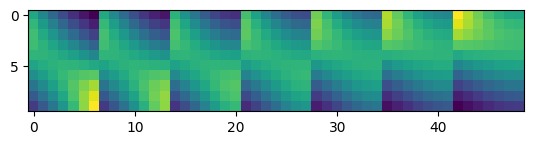

In [2]:
# The virtual environment  ENVIRONMENTAL CONSTANTS :
T = 11
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.5
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)
rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

plt.imshow(a[0])

Let's generate some synthetic data :

We need to define a loss function that takes a vector of parameters and observations as inputs, and returns some kind of cost ! Thankfully, we can use the negative log likelihood as that cost ! The main question is : how to treat the hyperparameters of each model ? 
We need to encode them so that they don't fall off the parameter space ! We thus perofrm gradient descent on a feature vector or real numbers encoding these parameters. For each model, we must thus define an encoder function for each of the models proposed ...

For each agent, we may now simulate a training depending on a set of parameters, as well as invert training data to fit these models. The next step is to perform parameter recovery checks to figure out if the behaviour of these agents allows us to efficiently retrieve these parameters :

1/3
2/3
3/3


C:\Users\annic\AppData\Local\Temp\ipykernel_36184\3603345612.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


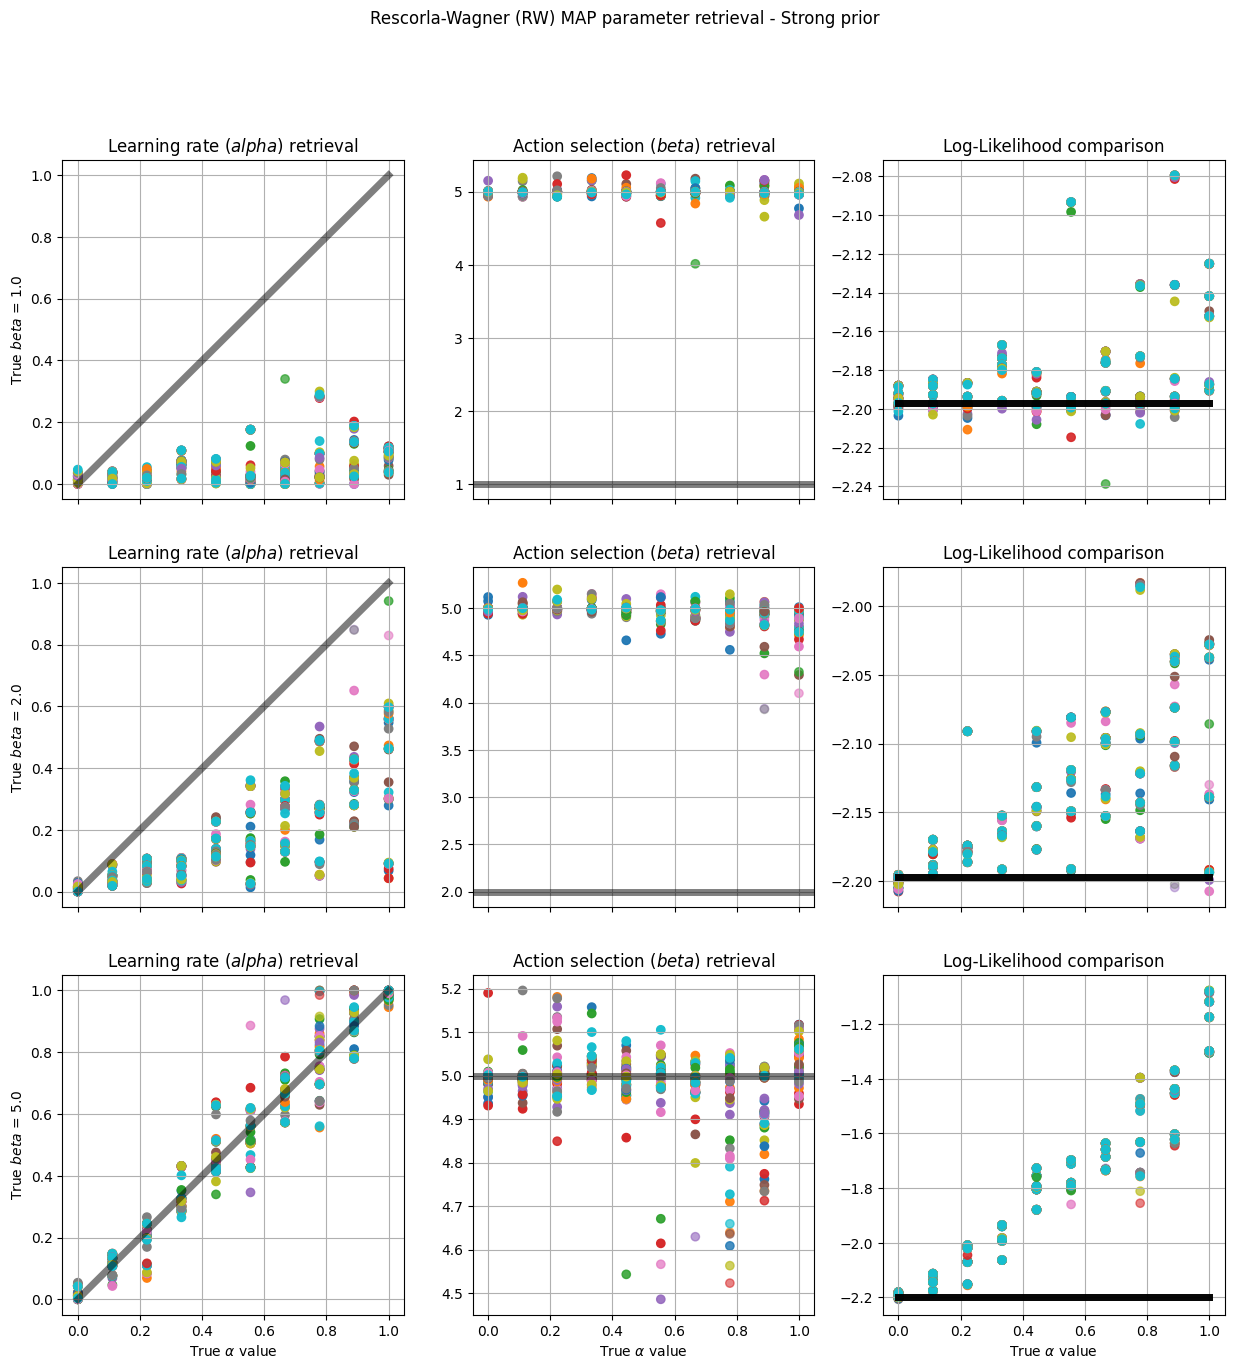

In [3]:
N_TRIALS = 10
N_vals = 10
N_subj_per_val = 5
N_heads = 10
Nsteps = 150

gt_alphas = np.linspace(0,1,N_vals)
gt_betas = np.array([1.0,2.0,5.0])

static_params = (9,)
rng_agent = partial(random_agent,constants=static_params)
tested_agent = partial(rescorla_wagner_agent,constants=static_params)
N_PARAMS = 2

# Let's assume the following priors, regardless of the true dynamics of the training :
# weak priors :
# tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,15.0))  
# strong priors :
tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,2.0))  


fig,axs = plt.subplots(gt_betas.shape[0],3,figsize=(15,5*gt_betas.shape[0]),sharex=True)
fig.suptitle("Rescorla-Wagner (RW) MAP parameter retrieval - Strong prior")
if axs.ndim==1:
    axs = np.expand_dims(axs,0)

for ax in axs.flatten():
    ax.grid()

for l,axs_line in enumerate(axs): 
    print("{}/{}".format(l+1,gt_betas.shape[0]))
    gt_beta = gt_betas[l]  
    axs_line[0].set_ylabel("True $beta$ = {}".format(gt_beta))
    
    infered_values = np.zeros((N_vals,N_subj_per_val,N_heads,N_PARAMS))
    neg_log_posteriors,log_likelihoods = np.zeros((N_vals,N_subj_per_val,N_heads)),np.zeros((N_vals,N_subj_per_val,N_heads))
    log_likelihoods_random_agent = np.zeros((N_vals,N_subj_per_val))

    
    for k,gt_alpha in enumerate(gt_alphas):
        TRUE_PARAMS = (gt_alpha,gt_beta)
                
        for j,subj in enumerate(range(N_subj_per_val)):
            subj_seed = np.random.randint(0,9999)
            
            SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(TRUE_PARAMS),N_TRIALS,subj_seed,False)

            

            # Multi-iteration based MAP : (we randomize the initial point and try to fall back on our feet :D )
            opt_vectors,(gt_map,loss_history,param_history),encoding_function = fit_map_agent(SUBJ_DATA,tested_agent,N_PARAMS,
                                                                    tested_priors,jr.PRNGKey(subj_seed),
                                                                    true_hyperparams=TRUE_PARAMS,                          
                                                                    num_steps=Nsteps,n_iter=N_heads,initial_window=[-10,10])
            
            lrs,action_selection_temp = vmap(lambda x : encoding_function(x))(opt_vectors)  # raw parameters
            
            infered_values[k,j,:,0] = lrs
            infered_values[k,j,:,1] = action_selection_temp
            
            neg_log_posteriors[k,j,:] = loss_history[-1]
            
            
            log_likelihoods[k,j,:] =   vmap(lambda x : compute_loglikelihood(SUBJ_DATA,tested_agent(encoding_function(x))))(opt_vectors)
            log_likelihoods_random_agent[k,j] = compute_loglikelihood(SUBJ_DATA,rng_agent(None)) # should always be -log(Nactions)

    # Low opacity for solutions with low log-likelihood : 
    best_solutions = jax.nn.softmax(5*log_likelihoods,axis=-1)
    head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)

    
    ax1 = axs_line[0]
    ax1.set_title("Learning rate ($alpha$) retrieval")
    ax1.plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black",lw=5,alpha=0.5)
    for subj in range(N_subj_per_val):
        for head in range(N_heads):
            ax1.scatter(gt_alphas,infered_values[:,subj,head,0],alpha=head_filters[:,subj,head])

    ax2 = axs_line[1]
    ax2.set_title("Action selection ($beta$) retrieval")
    ax2.axhline(gt_beta,color="black",lw=5,alpha=0.5)
    for subj in range(N_subj_per_val):
        for head in range(N_heads):
            ax2.scatter(gt_alphas,infered_values[:,subj,head,1],alpha=head_filters[:,subj,head])

    ax3 = axs_line[2]
    ax3.set_title("Log-Likelihood comparison")
    for subj in range(N_subj_per_val):
        ax3.plot(gt_alphas,log_likelihoods_random_agent[:,subj],color="black",alpha=0.5,lw=5)
        for head in range(N_heads):
            ax3.scatter(gt_alphas,log_likelihoods[:,subj,head],alpha=head_filters[:,subj,head])
    
    
ax1.set_xlabel(r'True $ \alpha $ value')
ax2.set_xlabel(r'True $ \alpha $ value')  
ax3.set_xlabel(r'True $ \alpha $ value')
fig.show()

The parameter retrieval graph above shows the impact of (action selection temperature) $\beta$ priors on the retrieval of parameter $\alpha$ (learning rate) in the Rescorla-Wagner model. When the action selection temperature is correctly estimated, the learning rate is nicely retrieved in all situations. However, when the true action selection temperature gets lower, the estimated learning rate is underestimated and the LL of the data given the model drops. This gets even worse for $\beta = 1$ where the LLs are difficult to disambiguate from the random model (black line). This makes sense as for low action selection temperature, the agent behaviour becomes more and more random, regardless of its learning mechanism. 

As a preliminary remark, one can see that in such a situation, it seems hard to correctly characterize our participants without making some assumptions about their intitial parameters. This line of thinking will extend to the Active Inference models we will develop for them.

In [54]:
N_points = 300

N_TRIALS = 10
N_vals = 10
N_subj_per_val = 1
N_heads = 10
Nsteps = 150

static_params = (9,)
rng_agent = partial(random_agent,constants=static_params)
tested_agent = partial(rescorla_wagner_agent,constants=static_params)
N_PARAMS = 2

# Let's assume the following priors, regardless of the true dynamics of the training :
# weak priors :
# tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,15.0))  
# strong priors :
tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,2.0))  

# Ground truth data generation
gt_parameters_sample_dist = (tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=10.0))
def sample_data(rng_key,dist_tuple):
    sampled_values = []
    for d in dist_tuple:
        rng_key,d_key = jr.split(rng_key)
        sampled_values.append(jnp.array(d.sample(seed = d_key)))
    return tuple(sampled_values)

true_values = np.zeros((N_points,N_PARAMS))
infered_values = np.zeros((N_points,N_subj_per_val,N_heads,N_PARAMS))
neg_log_posteriors,log_likelihoods = np.zeros((N_points,N_subj_per_val,N_heads)),np.zeros((N_points,N_subj_per_val,N_heads))
log_likelihoods_random_agent = np.zeros((N_points,N_subj_per_val))
log_likelihoods_actual_parameters = np.zeros((N_points,N_subj_per_val))

rngkey = jr.PRNGKey(0)
for point in range(N_points):
    print("{}/{}".format(point+1,N_points))
    
    rngkey,p_rng = jr.split(rngkey)
    TRUE_PARAMS = sample_data(p_rng,gt_parameters_sample_dist)
    
    true_values[point,:] = np.array(TRUE_PARAMS)
            
    for j,subj in enumerate(range(N_subj_per_val)):
        subj_seed = np.random.randint(0,9999)
        SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(TRUE_PARAMS),N_TRIALS,subj_seed,False)
        log_likelihoods_actual_parameters[point,j] = compute_loglikelihood(SUBJ_DATA,tested_agent(TRUE_PARAMS))
        

        # Multi-iteration based MAP : (we randomize the initial point and try to fall back on our feet :D )
        opt_vectors,(gt_map,loss_history,param_history),encoding_function = fit_map_agent(SUBJ_DATA,tested_agent,N_PARAMS,
                                                                tested_priors,jr.PRNGKey(subj_seed),
                                                                true_hyperparams=TRUE_PARAMS,                          
                                                                num_steps=Nsteps,n_iter=N_heads,initial_window=[-10,10])
        
        alpha,beta = vmap(lambda x : encoding_function(x))(opt_vectors)  # raw parameters
        
        infered_values[point,j,:,0] = alpha
        infered_values[point,j,:,1] = beta
        
        
        neg_log_posteriors[point,j,:] = loss_history[-1]
        
        
        log_likelihoods[point,j,:] =   vmap(lambda x : compute_loglikelihood(SUBJ_DATA,tested_agent(encoding_function(x))))(opt_vectors)
        log_likelihoods_random_agent[point,j] = compute_loglikelihood(SUBJ_DATA,rng_agent(None)) # should always be -log(Nactions)

1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300
30/300
31/300
32/300
33/300
34/300
35/300
36/300
37/300
38/300
39/300
40/300
41/300
42/300
43/300
44/300
45/300
46/300
47/300
48/300
49/300
50/300
51/300
52/300
53/300
54/300
55/300
56/300
57/300
58/300
59/300
60/300
61/300
62/300
63/300
64/300
65/300
66/300
67/300
68/300
69/300
70/300
71/300
72/300
73/300
74/300
75/300
76/300
77/300
78/300
79/300
80/300
81/300
82/300
83/300
84/300
85/300
86/300
87/300
88/300
89/300
90/300
91/300
92/300
93/300
94/300
95/300
96/300
97/300
98/300
99/300
100/300
101/300
102/300
103/300
104/300
105/300
106/300
107/300
108/300
109/300
110/300
111/300
112/300
113/300
114/300
115/300
116/300
117/300
118/300
119/300
120/300
121/300
122/300
123/300
124/300
125/300
126/300
127/300
128/300
129/300
130/300
131/300
132/300
133/300
134/300
135/300
136/300
137/300
138/300
139/

C:\Users\annic\AppData\Local\Temp\ipykernel_330624\3840391803.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


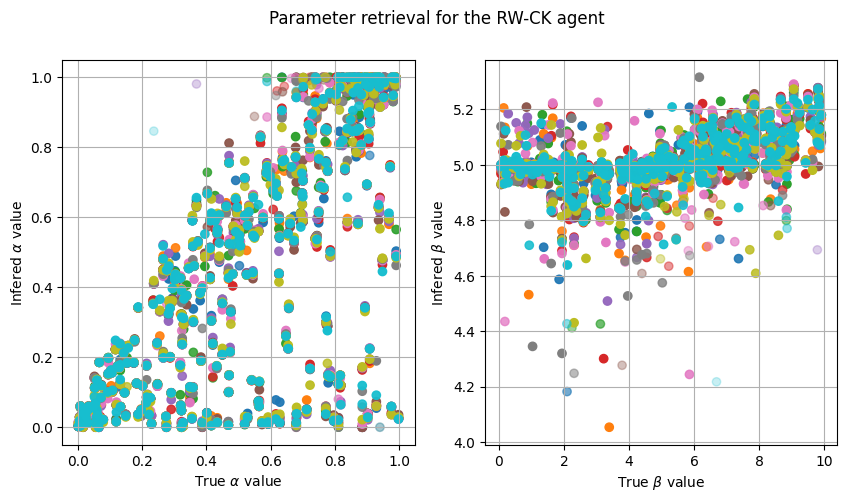

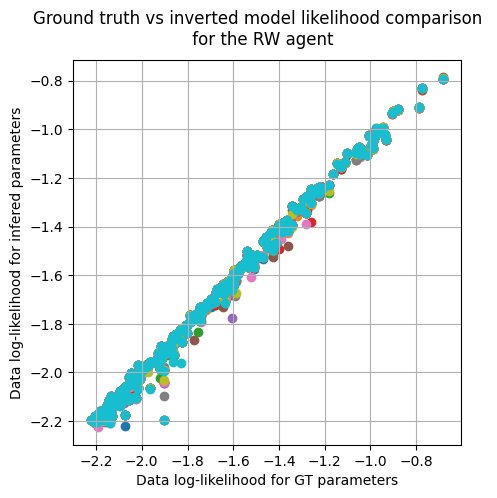

In [55]:
# Low opacity for solutions with low log-likelihood heads : 
best_solutions = jax.nn.softmax(10*log_likelihoods,axis=-1)
head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)

Nparams = true_values.shape[-1]
param_names = [r'$ \alpha $',r'$ \beta $']
fig,axs = plt.subplots(1,Nparams,figsize = (5*Nparams,5))
fig.suptitle("Parameter retrieval for the RW-CK agent")
for ax in axs : 
    ax.grid()
for param_idx in range(Nparams):
    ax = axs[param_idx]

    ax.set_xlabel("True " + param_names[param_idx] + " value")
    ax.set_ylabel("Infered " + param_names[param_idx] + " value")
    
    for subj in range(infered_values.shape[1]):
        for head in range(infered_values.shape[2]):
            ax.scatter(true_values[:,param_idx],infered_values[:,subj,head,param_idx],alpha = head_filters[:,subj,head])
fig.show()

fig_2,ax = plt.subplots(1,1,figsize=(5,5))
fig_2.suptitle("Ground truth vs inverted model likelihood comparison \n for the RW agent")
ax.grid()
ax.set_xlabel("Data log-likelihood for GT parameters")
ax.set_ylabel("Data log-likelihood for infered parameters")
for subj in range(log_likelihoods.shape[-2]):
    for head in range(log_likelihoods.shape[-1]):
        ax.scatter(log_likelihoods_actual_parameters[:,subj],log_likelihoods[:,subj,head])

1/4
2/4
3/4
4/4


C:\Users\annic\AppData\Local\Temp\ipykernel_36184\3902699905.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


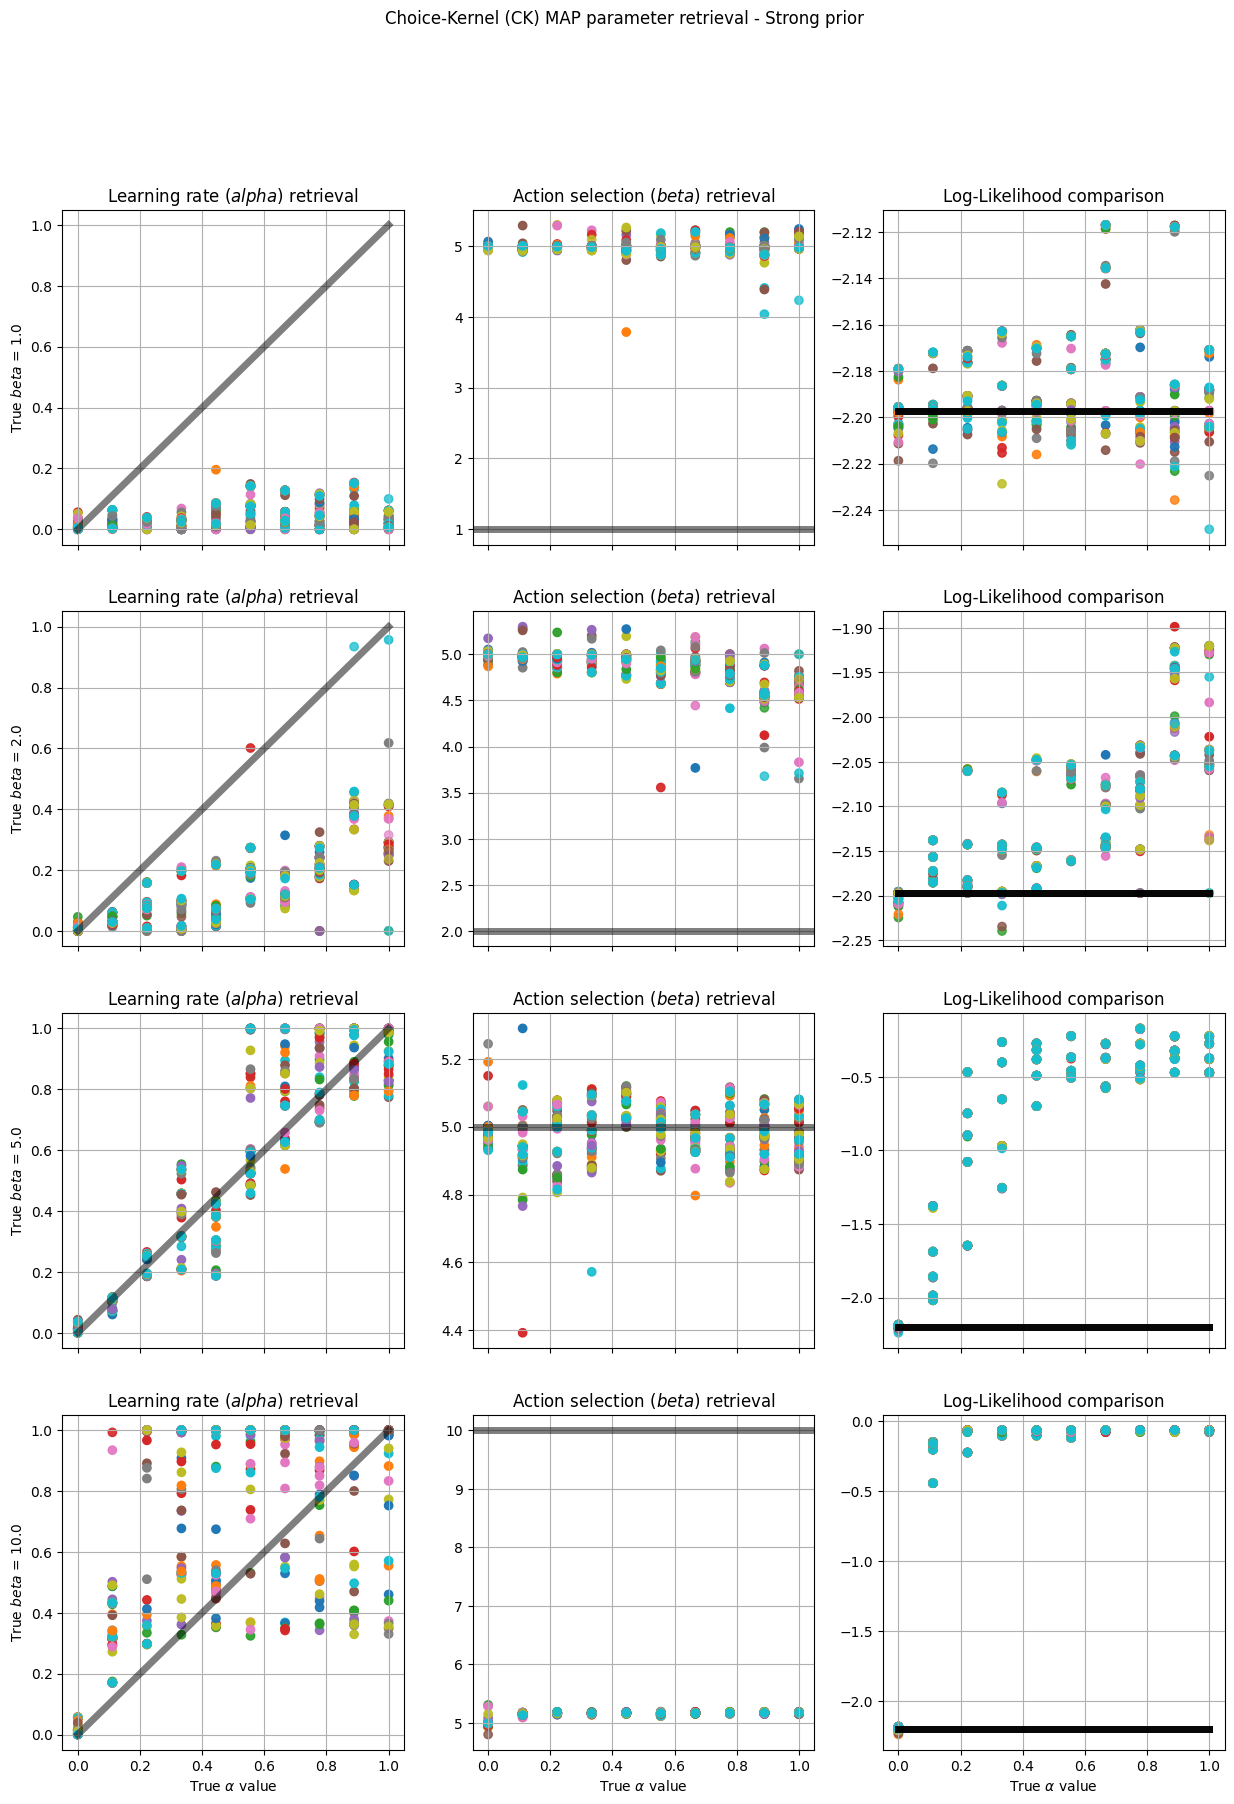

In [4]:
N_TRIALS = 10
N_vals = 10
N_subj_per_val = 5
N_heads = 10
Nsteps = 150

gt_alphas = np.linspace(0,1,N_vals)
gt_betas = np.array([1.0,2.0,5.0,10.0])

static_params = (9,)
rng_agent = partial(random_agent,constants=static_params)
tested_agent = partial(choice_kernel_agent,constants=static_params)
N_PARAMS = 2

# Let's assume the following priors, regardless of the true dynamics of the training :
# weak priors :
# tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,15.0))  
# strong priors :
tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,2.0))  


fig,axs = plt.subplots(gt_betas.shape[0],3,figsize=(15,5*gt_betas.shape[0]),sharex=True)
fig.suptitle("Choice-Kernel (CK) MAP parameter retrieval - Strong prior")
if axs.ndim==1:
    axs = np.expand_dims(axs,0)

for ax in axs.flatten():
    ax.grid()

for l,axs_line in enumerate(axs): 
    print("{}/{}".format(l+1,gt_betas.shape[0]))
    gt_beta = gt_betas[l]  
    axs_line[0].set_ylabel("True $beta$ = {}".format(gt_beta))
    
    infered_values = np.zeros((N_vals,N_subj_per_val,N_heads,N_PARAMS))
    neg_log_posteriors,log_likelihoods = np.zeros((N_vals,N_subj_per_val,N_heads)),np.zeros((N_vals,N_subj_per_val,N_heads))
    log_likelihoods_random_agent = np.zeros((N_vals,N_subj_per_val))

    
    for k,gt_alpha in enumerate(gt_alphas):
        TRUE_PARAMS = (gt_alpha,gt_beta)
                
        for j,subj in enumerate(range(N_subj_per_val)):
            subj_seed = np.random.randint(0,9999)
            
            SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(TRUE_PARAMS),N_TRIALS,subj_seed,False)

            

            # Multi-iteration based MAP : (we randomize the initial point and try to fall back on our feet :D )
            opt_vectors,(gt_map,loss_history,param_history),encoding_function = fit_map_agent(SUBJ_DATA,tested_agent,N_PARAMS,
                                                                    tested_priors,jr.PRNGKey(subj_seed),
                                                                    true_hyperparams=TRUE_PARAMS,                          
                                                                    num_steps=Nsteps,n_iter=N_heads,initial_window=[-10,10])
            
            lrs,action_selection_temp = vmap(lambda x : encoding_function(x))(opt_vectors)  # raw parameters
            
            infered_values[k,j,:,0] = lrs
            infered_values[k,j,:,1] = action_selection_temp
            
            neg_log_posteriors[k,j,:] = loss_history[-1]
            
            
            log_likelihoods[k,j,:] =   vmap(lambda x : compute_loglikelihood(SUBJ_DATA,tested_agent(encoding_function(x))))(opt_vectors)
            log_likelihoods_random_agent[k,j] = compute_loglikelihood(SUBJ_DATA,rng_agent(None)) # should always be -log(Nactions)

    # Low opacity for solutions with low log-likelihood : 
    best_solutions = jax.nn.softmax(5*log_likelihoods,axis=-1)
    head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)

    
    ax1 = axs_line[0]
    ax1.set_title("Learning rate ($alpha$) retrieval")
    ax1.plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black",lw=5,alpha=0.5)
    for subj in range(N_subj_per_val):
        for head in range(N_heads):
            ax1.scatter(gt_alphas,infered_values[:,subj,head,0],alpha=head_filters[:,subj,head])

    ax2 = axs_line[1]
    ax2.set_title("Action selection ($beta$) retrieval")
    ax2.axhline(gt_beta,color="black",lw=5,alpha=0.5)
    for subj in range(N_subj_per_val):
        for head in range(N_heads):
            ax2.scatter(gt_alphas,infered_values[:,subj,head,1],alpha=head_filters[:,subj,head])

    ax3 = axs_line[2]
    ax3.set_title("Log-Likelihood comparison")
    for subj in range(N_subj_per_val):
        ax3.plot(gt_alphas,log_likelihoods_random_agent[:,subj],color="black",alpha=0.5,lw=5)
        for head in range(N_heads):
            ax3.scatter(gt_alphas,log_likelihoods[:,subj,head],alpha=head_filters[:,subj,head])
    
    
ax1.set_xlabel(r'True $ \alpha $ value')
ax2.set_xlabel(r'True $ \alpha $ value')  
ax3.set_xlabel(r'True $ \alpha $ value')
fig.show()

This table shows the dependency of the MAP approach on the priors. When the prios are strong (like above), and during a task with very uncertain dynamics (like our BCI analog), the prior constitutes a significant portion of the evidence when trying to infer the posterior. 

More specifically, the likelihood of the data given the model often does not provide much evidence towards some markers of subject behaviour. It is very challenging to disambiguate causes of human behaviour given this training data and latent causes are often very correlated. It is our task to either : 
- a. Find models with more independent latent causes
- b. Design a task that allows us to correctly disambiguate those latent causes, while still allowing the training to proceed unimpeded (taking care of the "measuring the state of the subject causes a change in the subject training trajectory" effect)
- c. Fully report on the posterior factors correlations (show the full posterior over the parameters instead of a point estimate -> bayesian inference)

In [50]:
N_TRIALS = 10

N_points = 500
N_subj_per_val = 1
N_heads = 10
Nsteps = 150

static_params = (9,)
rng_agent = partial(random_agent,constants=static_params)
tested_agent = partial(rw_ck_agent,constants=static_params)
N_PARAMS = 4

# Let's assume the following priors, regardless of the true dynamics of the training :
# Very weak prior regarding the action selection temperatures:
tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,10.0),tfd.Uniform(low=0.0,high=1.0),tfd.Normal(1.0,10.0))

# Ground truth data generation
gt_parameters_sample_dist = (tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=10.0),tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=10.0))
def sample_data(rng_key,dist_tuple):
    sampled_values = []
    for d in dist_tuple:
        rng_key,d_key = jr.split(rng_key)
        sampled_values.append(jnp.array(d.sample(seed = d_key)))
    return tuple(sampled_values)

true_values = np.zeros((N_points,N_PARAMS))
infered_values = np.zeros((N_points,N_subj_per_val,N_heads,N_PARAMS))
neg_log_posteriors,log_likelihoods = np.zeros((N_points,N_subj_per_val,N_heads)),np.zeros((N_points,N_subj_per_val,N_heads))
log_likelihoods_random_agent = np.zeros((N_points,N_subj_per_val))
log_likelihoods_actual_parameters = np.zeros((N_points,N_subj_per_val))

rngkey = jr.PRNGKey(0)
for point in range(N_points):
    print("{}/{}".format(point+1,N_points))
    
    rngkey,p_rng = jr.split(rngkey)
    TRUE_PARAMS = sample_data(p_rng,gt_parameters_sample_dist)
    
    true_values[point,:] = np.array(TRUE_PARAMS)
            
    for j,subj in enumerate(range(N_subj_per_val)):
        subj_seed = np.random.randint(0,9999)
        SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(TRUE_PARAMS),N_TRIALS,subj_seed,False)
        log_likelihoods_actual_parameters[point,j] = compute_loglikelihood(SUBJ_DATA,tested_agent(TRUE_PARAMS))
        

        # Multi-iteration based MAP : (we randomize the initial point and try to fall back on our feet :D )
        opt_vectors,(gt_map,loss_history,param_history),encoding_function = fit_map_agent(SUBJ_DATA,tested_agent,N_PARAMS,
                                                                tested_priors,jr.PRNGKey(subj_seed),
                                                                true_hyperparams=TRUE_PARAMS,                          
                                                                num_steps=Nsteps,n_iter=N_heads,initial_window=[-10,10])
        
        alpha,beta,alpha_ck,beta_ck = vmap(lambda x : encoding_function(x))(opt_vectors)  # raw parameters
        
        infered_values[point,j,:,0] = alpha
        infered_values[point,j,:,1] = beta
        infered_values[point,j,:,2] = alpha_ck
        infered_values[point,j,:,3] = beta_ck
        
        
        neg_log_posteriors[point,j,:] = loss_history[-1]
        
        
        log_likelihoods[point,j,:] =   vmap(lambda x : compute_loglikelihood(SUBJ_DATA,tested_agent(encoding_function(x))))(opt_vectors)
        log_likelihoods_random_agent[point,j] = compute_loglikelihood(SUBJ_DATA,rng_agent(None)) # should always be -log(Nactions)

1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131/500
132/500
133/500
134/500
135/500
136/500
137/500
138/500
139/

C:\Users\annic\AppData\Local\Temp\ipykernel_36184\201881476.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


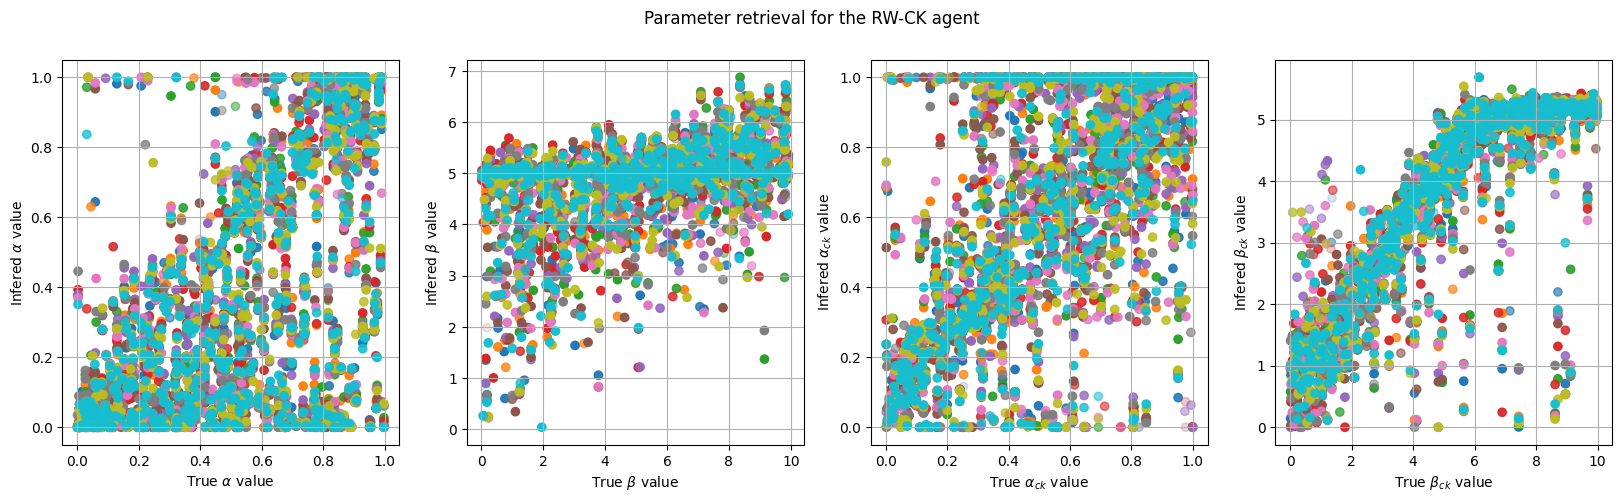

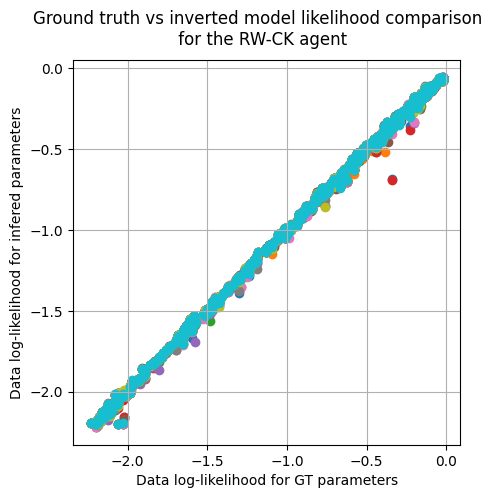

In [51]:
# Low opacity for solutions with low log-likelihood heads : 
best_solutions = jax.nn.softmax(10*log_likelihoods,axis=-1)
head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)

Nparams = true_values.shape[-1]
param_names = [r'$ \alpha $',r'$ \beta $',r'$ \alpha_{ck} $',r'$ \beta_{ck} $']
fig,axs = plt.subplots(1,Nparams,figsize = (5*Nparams,5))
fig.suptitle("Parameter retrieval for the RW-CK agent")
for ax in axs : 
    ax.grid()
for param_idx in range(Nparams):
    ax = axs[param_idx]

    ax.set_xlabel("True " + param_names[param_idx] + " value")
    ax.set_ylabel("Infered " + param_names[param_idx] + " value")
    
    for subj in range(infered_values.shape[1]):
        for head in range(infered_values.shape[2]):
            ax.scatter(true_values[:,param_idx],infered_values[:,subj,head,param_idx],alpha = head_filters[:,subj,head])
fig.show()

fig_2,ax = plt.subplots(1,1,figsize=(5,5))
fig_2.suptitle("Ground truth vs inverted model likelihood comparison \n for the RW-CK agent")
ax.grid()
ax.set_xlabel("Data log-likelihood for GT parameters")
ax.set_ylabel("Data log-likelihood for infered parameters")
for subj in range(log_likelihoods.shape[-2]):
    for head in range(log_likelihoods.shape[-1]):
        ax.scatter(log_likelihoods_actual_parameters[:,subj],log_likelihoods[:,subj,head])



In [34]:
N_TRIALS = 10

N_points = 500
N_subj_per_val = 1
N_heads = 10
Nsteps = 150


static_params_rng_agent = (9,)
rng_agent = partial(random_agent,constants=static_params_rng_agent)
static_params = (9,N_FEEDBACK_OUTCOMES)
tested_agent = partial(q_learning_agent,constants=static_params)
N_PARAMS = 5

# Let's assume the following priors, regardless of the true dynamics of the training :
# Very weak prior regarding the action selection temperatures:
tested_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,10.0),tfd.Uniform(low=0.0,high=1.0),tfd.Normal(1.0,10.0))

# Ground truth data generation
gt_parameters_sample_dist = (tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=10.0),tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=10.0))
def sample_data(rng_key,dist_tuple):
    sampled_values = []
    for d in dist_tuple:
        rng_key,d_key = jr.split(rng_key)
        sampled_values.append(jnp.array(d.sample(seed = d_key)))
    return tuple(sampled_values)


true_values = np.zeros((N_points,N_PARAMS))
infered_values = np.zeros((N_points,N_subj_per_val,N_heads,N_PARAMS))
neg_log_posteriors,log_likelihoods = np.zeros((N_points,N_subj_per_val,N_heads)),np.zeros((N_points,N_subj_per_val,N_heads))
log_likelihoods_random_agent = np.zeros((N_points,N_subj_per_val))
log_likelihoods_actual_parameters = np.zeros((N_points,N_subj_per_val))

rngkey = jr.PRNGKey(0)
for point in range(N_points):
    print("{}/{}".format(point+1,N_points))
    
    rngkey,p_rng = jr.split(rngkey)
    TRUE_PARAMS = sample_data(p_rng,gt_parameters_sample_dist)
    
    true_values[point,:] = np.array(TRUE_PARAMS)
            
    for j,subj in enumerate(range(N_subj_per_val)):
        subj_seed = np.random.randint(0,9999)
        SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(TRUE_PARAMS),N_TRIALS,subj_seed,False)
        log_likelihoods_actual_parameters[point,j] = compute_loglikelihood(SUBJ_DATA,tested_agent(TRUE_PARAMS))
        

        # Multi-iteration based MAP : (we randomize the initial point and try to fall back on our feet :D )
        opt_vectors,(gt_map,loss_history,param_history),encoding_function = fit_map_agent(SUBJ_DATA,tested_agent,N_PARAMS,
                                                                tested_priors,jr.PRNGKey(subj_seed),
                                                                true_hyperparams=TRUE_PARAMS,                          
                                                                num_steps=Nsteps,n_iter=N_heads,initial_window=[-10,10])
        
        alpha_plus,alpha_minus,beta,alpha_ck,beta_ck = vmap(lambda x : encoding_function(x))(opt_vectors)  # raw parameters
        
        infered_values[point,j,:,0] = alpha_plus
        infered_values[point,j,:,1] = alpha_minus
        infered_values[point,j,:,2] = beta
        infered_values[point,j,:,3] = alpha_ck
        infered_values[point,j,:,4] = beta_ck
        
        
        neg_log_posteriors[point,j,:] = loss_history[-1]
        
        
        log_likelihoods[point,j,:] =   vmap(lambda x : compute_loglikelihood(SUBJ_DATA,tested_agent(encoding_function(x))))(opt_vectors)
        log_likelihoods_random_agent[point,j] = compute_loglikelihood(SUBJ_DATA,rng_agent(None)) # should always be -log(Nactions)

1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131/500
132/500
133/500
134/500
135/500
136/500
137/500
138/500
139/

C:\Users\annic\AppData\Local\Temp\ipykernel_36184\3705069408.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


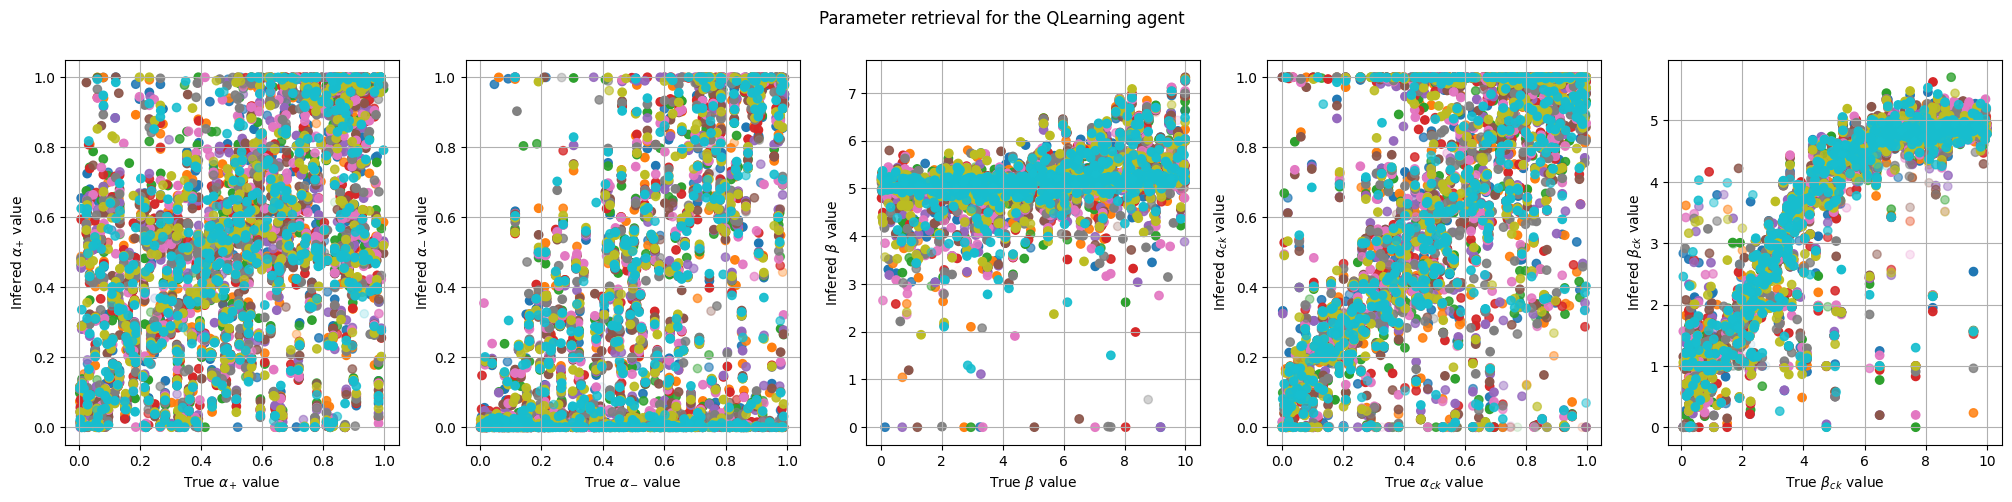

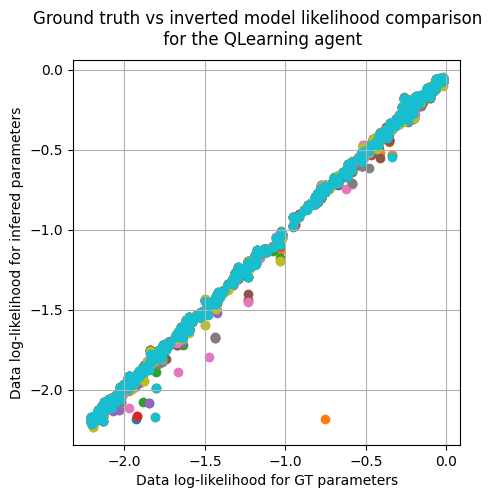

In [49]:
# Low opacity for solutions with low log-likelihood heads : 
best_solutions = jax.nn.softmax(10*log_likelihoods,axis=-1)
head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)

Nparams = true_values.shape[-1]
param_names = [r'$ \alpha_{+} $',r'$ \alpha_{-} $',r'$ \beta $',r'$ \alpha_{ck} $',r'$ \beta_{ck} $']
fig,axs = plt.subplots(1,Nparams,figsize = (5*Nparams,5))
fig.suptitle("Parameter retrieval for the QLearning agent")
for ax in axs : 
    ax.grid()
for param_idx in range(Nparams):
    ax = axs[param_idx]

    ax.set_xlabel("True " + param_names[param_idx] + " value")
    ax.set_ylabel("Infered " + param_names[param_idx] + " value")
    
    for subj in range(infered_values.shape[1]):
        for head in range(infered_values.shape[2]):
            ax.scatter(true_values[:,param_idx],infered_values[:,subj,head,param_idx],alpha = head_filters[:,subj,head])
fig.show()

fig_2,ax = plt.subplots(1,1,figsize=(5,5))
fig_2.suptitle("Ground truth vs inverted model likelihood comparison \n for the QLearning agent")
ax.grid()
ax.set_xlabel("Data log-likelihood for GT parameters")
ax.set_ylabel("Data log-likelihood for infered parameters")
for subj in range(log_likelihoods.shape[-2]):
    for head in range(log_likelihoods.shape[-1]):
        ax.scatter(log_likelihoods_actual_parameters[:,subj],log_likelihoods[:,subj,head])


In [33]:
N_TRIALS = 10

N_points = 100
N_subj_per_val = 1
N_heads = 10
Nsteps = 150

static_params_rng_agent = (9,)
rng_agent = partial(random_agent,constants=static_params_rng_agent)
static_params = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions_distance" :3,
    "N_actions_position" :9,
    "N_actions_angle" :9,
    
    "Th" : 2
}
tested_agent = partial(active_inference_basic_1D,constants=static_params)

# Let's assume the following priors, regardless of the true dynamics of the training :
# Very weak prior regarding the action selection temperatures:
tested_priors = {
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": tfd.Normal(1.0,0.5), # Initial concentrations should be rather low
    "transition_stickiness": tfd.Uniform(low=-0.01,high=1000.0),
    "transition_learning_rate" : tfd.Uniform(low=-0.01,high=1000.0),
    "state_interpolation_temperature" : tfd.Uniform(low=-0.01,high=1000.0),
    
    "initial_state_concentration": tfd.Uniform(low=-0.01,high=1000.0),
    
    "feedback_expected_std" : tfd.Uniform(low=-0.0,high=1000.0),
    "emission_concentration" : tfd.Uniform(low=-0.01,high=1000.0),
    "emission_stickiness" : tfd.Uniform(low=-0.01,high=1000.0),
    
    "reward_seeking" :tfd.Normal(10.0,10.0),
    
    "action_selection_temperature" : tfd.Normal(10.0,5.0),
}
N_PARAMS = len(tested_priors)


# # Ground truth data generation
# gt_parameters_sample_dist = {
#     # ----------------------------------------------------------------------------------------------------
#     # Model parameters : these should interact with the model components in a differentiable manner
#     "transition_concentration": tfd.Uniform(low=0.01,high=1.0), # Initial concentrations should be rather low
#     "transition_stickiness": tfd.Uniform(low=0.01,high=1.0),
#     "transition_learning_rate" : tfd.Uniform(low=0.01,high=1.0),
#     "state_interpolation_temperature" :tfd.Uniform(low=0.01,high=10.0),
    
#     "initial_state_concentration": tfd.Uniform(low=0.01,high=10.0),
    
#     "feedback_expected_std" : tfd.Uniform(low=0.0,high=1.0),
#     "emission_concentration" : tfd.Uniform(low=0.01,high=10.0),
#     "emission_stickiness" : tfd.Uniform(low=0.01,high=10.0),
    
#     "reward_seeking" :tfd.Uniform(0.0,10.0),
    
#     "action_selection_temperature" :  tfd.Uniform(low=0.0,high=10.0),
# }

gt_parameters_sample_dist = {
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0, # Initial concentrations should be rather low
    "transition_stickiness": 1.0,
    "transition_learning_rate" : tfd.Uniform(low=0.01,high=2.0),
    "state_interpolation_temperature" : tfd.Uniform(low=0.01,high=1.0),
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : tfd.Uniform(low=0.001,high=1.0),
    "emission_concentration" : 0.0,
    "emission_stickiness" : 100.0,
    
    "reward_seeking" :tfd.Normal(10.0,5.0),
    
    "action_selection_temperature" :  10.0,
}


def sample_data(rng_key,dist_dict):
    sampled_values = {}
    for key, d in dist_dict.items():
        if isinstance(d, tfd.Distribution):
            rng_key,d_key = jr.split(rng_key)
            sampled_values[key] = jnp.array(d.sample(seed = d_key))
        else : 
            sampled_values[key] = d
    return sampled_values

# param_sampled = sample_data(jr.PRNGKey(0),gt_parameters_sample_dist)
# print(param_sampled)
# print(np.fromiter(param_sampled.values(), dtype=float))


true_values = np.zeros((N_points,N_PARAMS))
infered_values = np.zeros((N_points,N_subj_per_val,N_heads,N_PARAMS))
neg_log_posteriors,log_likelihoods = np.zeros((N_points,N_subj_per_val,N_heads)),np.zeros((N_points,N_subj_per_val,N_heads))
log_likelihoods_random_agent = np.zeros((N_points,N_subj_per_val))
log_likelihoods_actual_parameters = np.zeros((N_points,N_subj_per_val))

rngkey = jr.PRNGKey(0)
for point in range(N_points):
    print("{}/{}".format(point+1,N_points))
    
    rngkey,p_rng = jr.split(rngkey)
    TRUE_PARAMS = sample_data(p_rng,gt_parameters_sample_dist)
    
    true_values[point,:] = np.fromiter(TRUE_PARAMS.values(), dtype=float)

    for j,subj in enumerate(range(N_subj_per_val)):
        subj_seed = np.random.randint(0,9999)
        SUBJ_DATA = generate_synthetic_data(ENVIRONMENT,tested_agent(TRUE_PARAMS),N_TRIALS,subj_seed,False)
        # print(TRUE_PARAMS)
        log_likelihoods_actual_parameters[point,j] = compute_loglikelihood(SUBJ_DATA,tested_agent(TRUE_PARAMS))
        # print(log_likelihoods_actual_parameters[point,:])
        # Multi-iteration based MAP : (we randomize the initial point and try to fall back on our feet :D )
        opt_vectors,(gt_map,loss_history,param_history),encoding_function = fit_map_agent(SUBJ_DATA,tested_agent,N_PARAMS,
                                                                tested_priors,jr.PRNGKey(subj_seed),
                                                                true_hyperparams=TRUE_PARAMS,                          
                                                                num_steps=Nsteps,n_iter=N_heads,
                                                                initial_window=[-10,10],verbose=True)
        
        
        parameter_dict = vmap(lambda x : encoding_function(x))(opt_vectors)  # raw parameters
                
        infered_values[point,j,:,0] = parameter_dict["transition_concentration"]
        infered_values[point,j,:,1] = parameter_dict["transition_stickiness"]
        infered_values[point,j,:,2] = parameter_dict["transition_learning_rate"]
        infered_values[point,j,:,3] = parameter_dict["state_interpolation_temperature"]
        infered_values[point,j,:,4] = parameter_dict["initial_state_concentration"]
        infered_values[point,j,:,5] = parameter_dict["feedback_expected_std"]
        infered_values[point,j,:,6] = parameter_dict["emission_concentration"]
        infered_values[point,j,:,7] = parameter_dict["emission_stickiness"]
        infered_values[point,j,:,8] = parameter_dict["reward_seeking"]
        infered_values[point,j,:,9] = parameter_dict["action_selection_temperature"]
        
        neg_log_posteriors[point,j,:] = loss_history[-1]
        
        
        log_likelihoods[point,j,:] =   vmap(lambda x : compute_loglikelihood(SUBJ_DATA,tested_agent(encoding_function(x))))(opt_vectors)
        log_likelihoods_random_agent[point,j] = compute_loglikelihood(SUBJ_DATA,rng_agent(None)) # should always be -log(Nactions)

1/100
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
(10,)
(10, 5)
(11, 5)
step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([ 60.9607  , 143.17169 ,  66.176506, 135.94788 ,  60.51473 ,
        60.773823,  60.991203, 110.618034, 110.24492 , 128.42894 ],      dtype=float32)
  batch_dim = 0
step 10, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([ 60.900974, 119.020424,  60.977734, 112.83987 ,  59.878777,
        60.65872 ,  60.940586,  92.061844,  92.060394, 106.928925],      dtype=float32)
  batch_dim = 0
step 20, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([60.817097, 99.43367 , 59.073402, 94.306435, 59.02335 , 60.45669 ,
       60.82952 , 78.02057 , 78.3968

In [31]:
# print("__________________________________________________________________________")
# print("Final log likelihoods :")
# print( log_likelihoods)
# print("Log likelihood for the true causing parameters :")
# print( log_likelihoods_actual_parameters)
# print("__________________________________________________________________________")

print(log_likelihoods_actual_parameters)

[[-1.4514854 ]
 [-1.40057445]
 [-1.39681423]
 [-2.19964767]
 [-2.14382935]
 [-2.21637559]
 [-2.19772434]
 [-1.07139826]
 [-2.07348418]
 [-0.49740344]]


C:\Users\annic\AppData\Local\Temp\ipykernel_330624\69241057.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


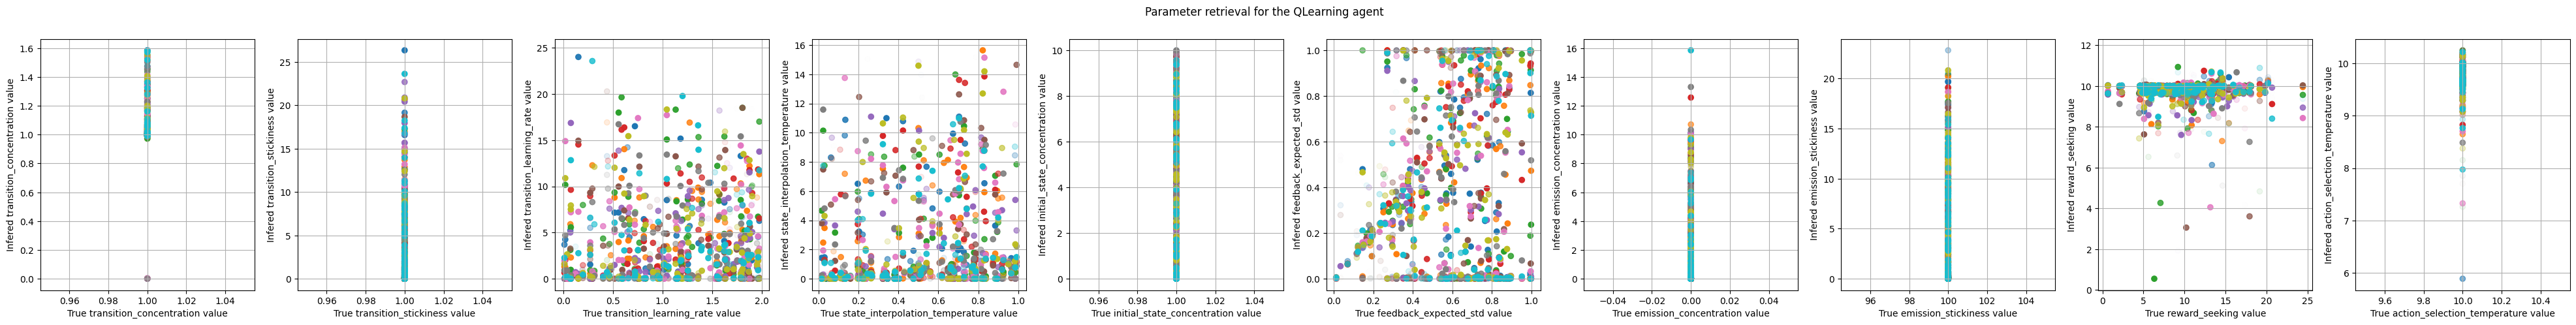

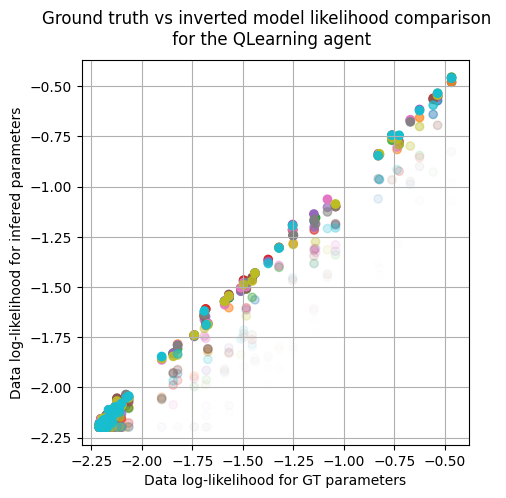

In [45]:
# Low opacity for solutions with low log-likelihood heads : 
best_solutions = jax.nn.softmax(10*log_likelihoods,axis=-1)
head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)
head_filters = np.array(head_filters)

Nparams = true_values.shape[-1]
param_names = [r'transition_concentration',r'transition_stickiness',r'transition_learning_rate',r'state_interpolation_temperature',r'initial_state_concentration',
               'feedback_expected_std','emission_concentration',
               'emission_stickiness',"reward_seeking","action_selection_temperature"]
fig,axs = plt.subplots(1,Nparams,figsize = (5*Nparams,5))
fig.suptitle("Parameter retrieval for the QLearning agent")
for ax in axs : 
    ax.grid()
    # ax.set_ylim([0,1])
for param_idx in range(Nparams):
    ax = axs[param_idx]

    ax.set_xlabel("True " + param_names[param_idx] + " value")
    ax.set_ylabel("Infered " + param_names[param_idx] + " value")
    
    for subj in range(infered_values.shape[1]):
        for head in range(infered_values.shape[2]):
            ax.scatter(true_values[:,param_idx],infered_values[:,subj,head,param_idx],alpha = head_filters[:,subj,head])
fig.show()

fig_2,ax = plt.subplots(1,1,figsize=(5,5))
fig_2.suptitle("Ground truth vs inverted model likelihood comparison \n for the QLearning agent")
ax.grid()
ax.set_xlabel("Data log-likelihood for GT parameters")
ax.set_ylabel("Data log-likelihood for infered parameters")
for subj in range(log_likelihoods.shape[-2]):
    for head in range(log_likelihoods.shape[-1]):
        ax.scatter(log_likelihoods_actual_parameters[:,subj],log_likelihoods[:,subj,head],alpha = head_filters[:,subj,head])

What a mess ! It seems that a huge concentration of the results are stacked around very low log likelihoods ... 

In practice, it means that most parameter sets in our Active Inference modelisation of the paradigm lead to noisy, random behaviour. Any organized behaviour is correlated to a very specific subspace of the parameters (i.e. the subject need to be motivated to reach the goal, their action selection must be based on planning, they need to have some level of confidence regarding the indications of the feedback.) 

The parameter retrieval also seems very noisy. But, let's try to remove those low log likelihoood results :

C:\Users\annic\AppData\Local\Temp\ipykernel_330624\2262770717.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


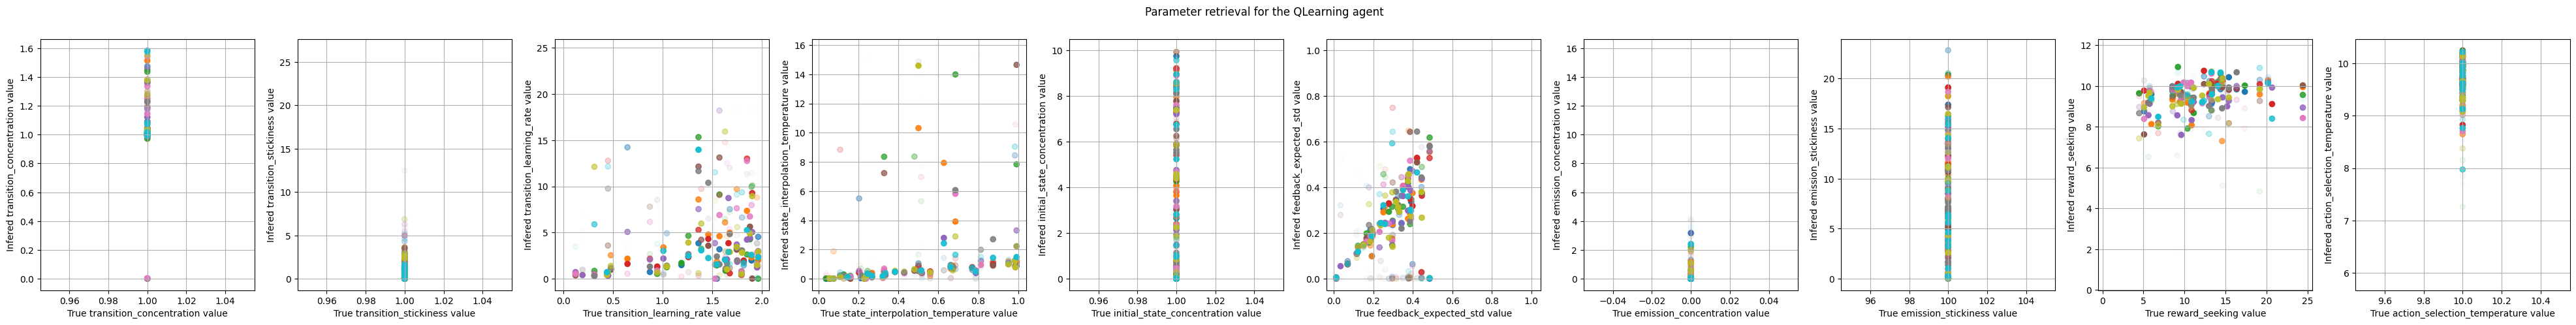

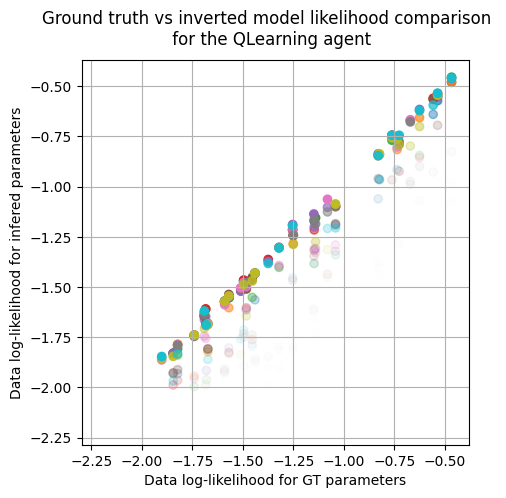

In [51]:
# Low opacity for solutions with low log-likelihood heads : 
best_solutions = jax.nn.softmax(10*log_likelihoods,axis=-1)
head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)

head_filters = np.array(head_filters)

# Only look at results significatively different from a random set of actions :
LL_limit = -2.0  # The lower this goes, the higher the p-value
head_filters[log_likelihoods<LL_limit] = 0.0

Nparams = true_values.shape[-1]
param_names = [r'transition_concentration',r'transition_stickiness',r'transition_learning_rate',r'state_interpolation_temperature',r'initial_state_concentration',
               'feedback_expected_std','emission_concentration',
               'emission_stickiness',"reward_seeking","action_selection_temperature"]
fig,axs = plt.subplots(1,Nparams,figsize = (5*Nparams,5))
fig.suptitle("Parameter retrieval for the QLearning agent")
for ax in axs : 
    ax.grid()
    # ax.set_ylim([0,1])
for param_idx in range(Nparams):
    ax = axs[param_idx]

    ax.set_xlabel("True " + param_names[param_idx] + " value")
    ax.set_ylabel("Infered " + param_names[param_idx] + " value")
    
    for subj in range(infered_values.shape[1]):
        for head in range(infered_values.shape[2]):
            ax.scatter(true_values[:,param_idx],infered_values[:,subj,head,param_idx],alpha = head_filters[:,subj,head])
fig.show()

fig_2,ax = plt.subplots(1,1,figsize=(5,5))
fig_2.suptitle("Ground truth vs inverted model likelihood comparison \n for the QLearning agent")
ax.grid()
ax.set_xlabel("Data log-likelihood for GT parameters")
ax.set_ylabel("Data log-likelihood for infered parameters")
for subj in range(log_likelihoods.shape[-2]):
    for head in range(log_likelihoods.shape[-1]):
        ax.scatter(log_likelihoods_actual_parameters[:,subj],log_likelihoods[:,subj,head],alpha = head_filters[:,subj,head])

The retrieval gets much better, revealing that it is very hard to retrieve the agent model parameters for a specific range of input parameters (here, if the agents did not have any confidence in the feedback signal, it resulted in very erratic behaviour hard to differentiate from completely random behaviour.)

In fact, for the vast majority of model parameter sets, the agent behaviour is undistinguishable from a fully random agent (the likelihood of generated data given the true parameters is just as low as a completely random agent).

Can we still recover anything in that case ?

C:\Users\annic\AppData\Local\Temp\ipykernel_330624\3762870362.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


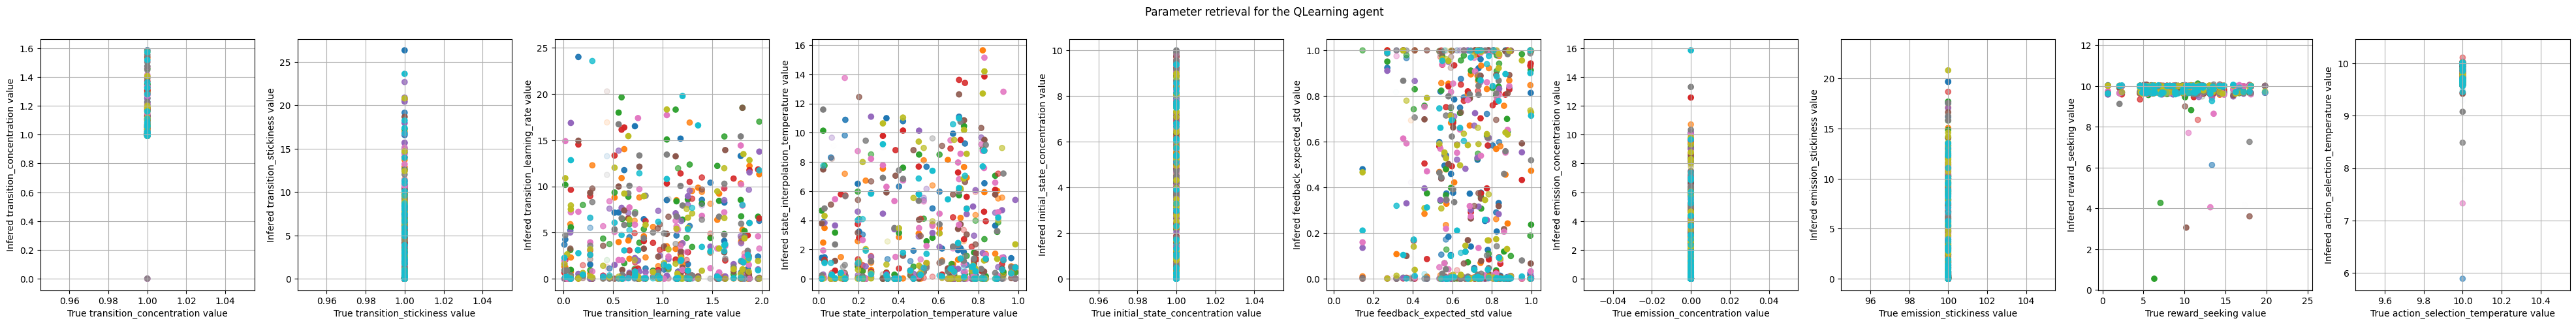

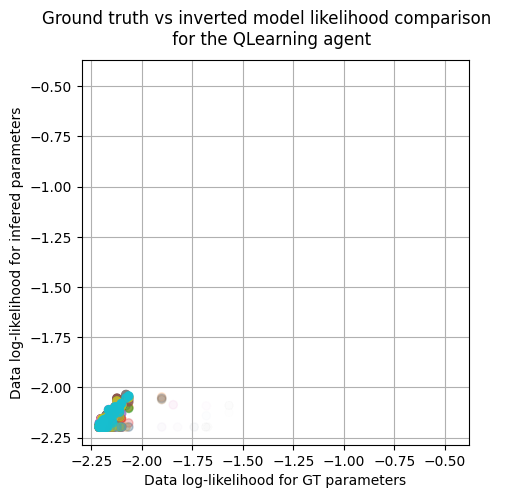

In [52]:
# Low opacity for solutions with low log-likelihood heads : 
best_solutions = jax.nn.softmax(10*log_likelihoods,axis=-1)
head_filters = best_solutions/jnp.max(best_solutions,axis=-1,keepdims=True)

head_filters = np.array(head_filters)

# Only look at results looking like a random set of actions :
LL_limit = -2.0  # The lower this goes, the higher the p-value
head_filters[log_likelihoods>LL_limit] = 0.0

Nparams = true_values.shape[-1]
param_names = [r'transition_concentration',r'transition_stickiness',r'transition_learning_rate',r'state_interpolation_temperature',r'initial_state_concentration',
               'feedback_expected_std','emission_concentration',
               'emission_stickiness',"reward_seeking","action_selection_temperature"]
fig,axs = plt.subplots(1,Nparams,figsize = (5*Nparams,5))
fig.suptitle("Parameter retrieval for the QLearning agent")
for ax in axs : 
    ax.grid()
    # ax.set_ylim([0,1])
for param_idx in range(Nparams):
    ax = axs[param_idx]

    ax.set_xlabel("True " + param_names[param_idx] + " value")
    ax.set_ylabel("Infered " + param_names[param_idx] + " value")
    
    for subj in range(infered_values.shape[1]):
        for head in range(infered_values.shape[2]):
            ax.scatter(true_values[:,param_idx],infered_values[:,subj,head,param_idx],alpha = head_filters[:,subj,head])
fig.show()

fig_2,ax = plt.subplots(1,1,figsize=(5,5))
fig_2.suptitle("Ground truth vs inverted model likelihood comparison \n for the QLearning agent")
ax.grid()
ax.set_xlabel("Data log-likelihood for GT parameters")
ax.set_ylabel("Data log-likelihood for infered parameters")
for subj in range(log_likelihoods.shape[-2]):
    for head in range(log_likelihoods.shape[-1]):
        ax.scatter(log_likelihoods_actual_parameters[:,subj],log_likelihoods[:,subj,head],alpha = head_filters[:,subj,head])